In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import keras_tuner
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [22]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [23]:
img_size = 180
batch_size = 32
train_dataset = image_dataset_from_directory(
    "data/train",
    image_size=(img_size, img_size),
    batch_size=batch_size)
validation_dataset = image_dataset_from_directory(
    "data/val",
    image_size=(img_size, img_size),
    batch_size=batch_size)
test_dataset = image_dataset_from_directory(
    "data/test",
    image_size=(img_size, img_size),
    batch_size=batch_size)

Found 8819 files belonging to 15 classes.
Found 1891 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.


In [24]:
# Function to preprocess the dataset
def preprocess_dataset(dataset):
    def process(image, label):
        label = to_categorical(label, num_classes=15)
        return image, label
    return dataset.map(process)

# Preprocess the datasets
train_dataset = preprocess_dataset(train_dataset)
validation_dataset = preprocess_dataset(validation_dataset)
test_dataset = preprocess_dataset(test_dataset)

In [25]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Definición del modelo

In [26]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

# Apply normalization and data augmentation to the input
inputs = base_model.input
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x) # Normalización

# Use the base model excluding the last two layers
x = base_model(x, training=False)  # Freeze the base model during training

x = GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512,'relu')(x)
x = Dense(15, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,985,039 (57.16 MB)

 Trainable params: 14,985,039 (57.16 MB)

 Non-trainable params: 0 (0.00 B)

# Checkpoints


In [27]:
model_name = "model.keras"

# Guarda el modelo si tiene una mejor val_loss que antes.
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

# Detiene el entrenamiento si la val_loss no mejora en 5 epochs.
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

# Reduce el learning rate si la val_loss no mejora en 3 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

# Entrenamiento del modelo


In [28]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.0619 - loss: 2.7489
Epoch 1: val_loss improved from inf to 2.71202, saving model to model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 161s 568ms/step - accuracy: 0.0619 - loss: 2.7488 - val_accuracy: 0.0714 - val_loss: 2.7120 - learning_rate: 1.0000e-04
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.0709 - loss: 2.6991
Epoch 2: val_loss improved from 2.71202 to 2.67877, saving model to model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 165s 599ms/step - accuracy: 0.0709 - loss: 2.6991 - val_accuracy: 0.0814 - val_loss: 2.6788 - learning_rate: 1.0000e-04
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.0958 - loss: 2.6524
Epoch 3: val_loss improved from 2.67877 to 2.62562, saving model to model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 170s 616ms/step - accuracy: 0.0959 - loss: 2.6524 - val_accuracy: 0.1079 - val_loss: 2.6256 - learning_rate: 1.0000e-04
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step

# Curvas de aprendizaje

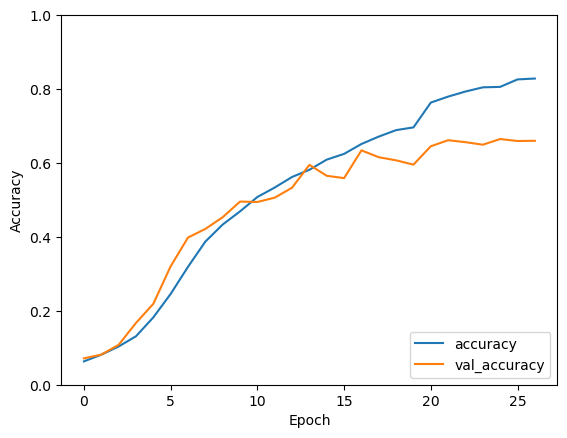

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

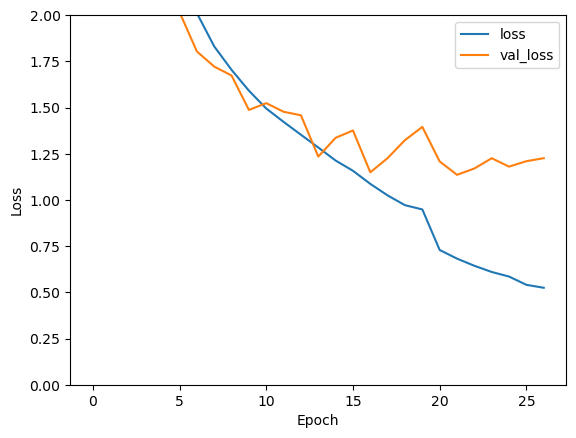

In [30]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()

In [32]:
# Save model
model.save("/home/luciano/Documentos/Facultad/4to/2_semestre/Inteligencia_Artificial_2/ia2-uncuyo-2024/human-action-recognition/humanActionRecognition/models/fineTunedModel.keras")